<a href="https://colab.research.google.com/github/prachika2507/Birdcall_Identification/blob/main/CS328_Project_ADP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<h1>Bird Call Identification</h1>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Loading Data from Kaggle

In [ ]:
#Configuration environment
import os

os.environ['KAGGLE_USERNAME'] = "divyanshutripathy" # username from the json file
os.environ['KAGGLE_KEY'] = "2da3ce785b0883e8d34abd75bd83e8ac" # key from the json file

In [ ]:
!kaggle competitions download -c "birdclef-2022"

  2% 139M/6.12G [00:00<00:29, 220MB/s]
User cancelled operation


In [ ]:
!unzip "birdclef-2022.zip"

In [ ]:
!cp -R train_audio drive/MyDrive/Data\ Science/Project

In [ ]:
!kaggle competitions download -c "birdclef-2022" -f "train_metadata.csv"

  0% 0.00/389k [00:00<?, ?B/s]
100% 389k/389k [00:00<00:00, 95.4MB/s]


In [ ]:
!unzip "train_metadata.csv.zip"

Archive:  train_metadata.csv.zip
  inflating: train_metadata.csv      


# Project

In [ ]:
import soundfile as sf
import numpy as np
from IPython.display import Audio
from sklearn.decomposition import TruncatedSVD
from statistics import mode
import  librosa as lr
import librosa.display
from glob import glob
import pandas as pd
from sklearn.model_selection import train_test_split
from collections import Counter

from sklearn.manifold import TSNE

# Clustering Algorithms
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from sklearn.cluster import Birch

# Classifiers
from sklearn.ensemble import RandomForestClassifier

from matplotlib import pyplot as plt
import seaborn as sns
%matplotlib inline

In [ ]:
%tensorflow_version 2.x
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [ ]:
data_path = "drive/MyDrive/Data Science/Project/"

## Analysing Audio Files

In [ ]:
train_data = pd.read_csv('train_metadata.csv')
train_data.head()

primary_label                secondary_labels                     type  \
0       afrsil1                              []  ['call', 'flight call']   
1       afrsil1  ['houspa', 'redava', 'zebdov']                 ['call']   
2       afrsil1                              []         ['call', 'song']   
3       afrsil1                              []   ['alarm call', 'call']   
4       afrsil1                              []          ['flight call']   

   latitude  longitude  scientific_name         common_name          author  \
0   12.3910    -1.4930  Euodice cantans  African Silverbill       Bram Piot   
1   19.8801  -155.7254  Euodice cantans  African Silverbill        Dan Lane   
2   16.2901   -16.0321  Euodice cantans  African Silverbill       Bram Piot   
3   17.0922    54.2958  Euodice cantans  African Silverbill  Oscar Campbell   
4   21.4581  -157.7252  Euodice cantans  African Silverbill   Ross Gallardy   

                                             license  rating   time  \
0  Creative Commons Attribution-NonCommercial-Sha...     2.5  08:00   
1  Creative Commons Attribution-NonCommercial-Sha...     3.5  08:30   
2  Creative Commons Attribution-NonCommercial-Sha...     4.0  11:30   
3  Creative Commons Attribution-NonCommercial-Sha...     4.0  11:00   
4  Creative Commons Attribution-NonCommercial-Sha...     3.0  16:30   

                                 url              filename  
0  https://www.xeno-canto.org/125458  afrsil1/XC125458.ogg  
1  https://www.xeno-canto.org/175522  afrsil1/XC175522.ogg  
2  https://www.xeno-canto.org/177993  afrsil1/XC177993.ogg  
3  https://www.xeno-canto.org/205893  afrsil1/XC205893.ogg  
4  https://www.xeno-canto.org/207431  afrsil1/XC207431.ogg

In [ ]:
# Randomly sampling 5 bird species

birds = np.random.choice(np.unique(train_data.primary_label), 5)

array(['commyn', 'yefcan', 'akikik', 'hawama', 'sheowl'], dtype=object)

In [ ]:
birds = ['commyn', 'yefcan', 'akikik', 'hawama', 'sheowl']

In [ ]:
bird_sounds = {}
for bird in birds:
  filtered = train_data[train_data['primary_label'] == bird]
  samp = filtered.sample(1, random_state=42)
  bird_sounds[bird] = f"{data_path}train_audio/{samp.filename.values[0]}"
bird_sounds

{'akikik': 'drive/MyDrive/Data Science/Project/train_audio/akikik/XC317034.ogg',
 'commyn': 'drive/MyDrive/Data Science/Project/train_audio/commyn/XC551659.ogg',
 'hawama': 'drive/MyDrive/Data Science/Project/train_audio/hawama/XC175238.ogg',
 'sheowl': 'drive/MyDrive/Data Science/Project/train_audio/sheowl/XC489389.ogg',
 'yefcan': 'drive/MyDrive/Data Science/Project/train_audio/yefcan/XC355032.ogg'}

In [ ]:
Audio(bird_sounds['akikik'])

In [ ]:
Audio(bird_sounds['commyn'])

In [ ]:
Audio(bird_sounds['sheowl'])

In [ ]:
Audio(bird_sounds["yefcan"])

In [ ]:
Audio(bird_sounds["hawama"])

## Loading audio files to processable data

In [ ]:
bird_samps = {}

for bird, sound in bird_sounds.items():
  diff = lr.load(sound)
  bird_samps[bird] = diff

### Waveform Plot

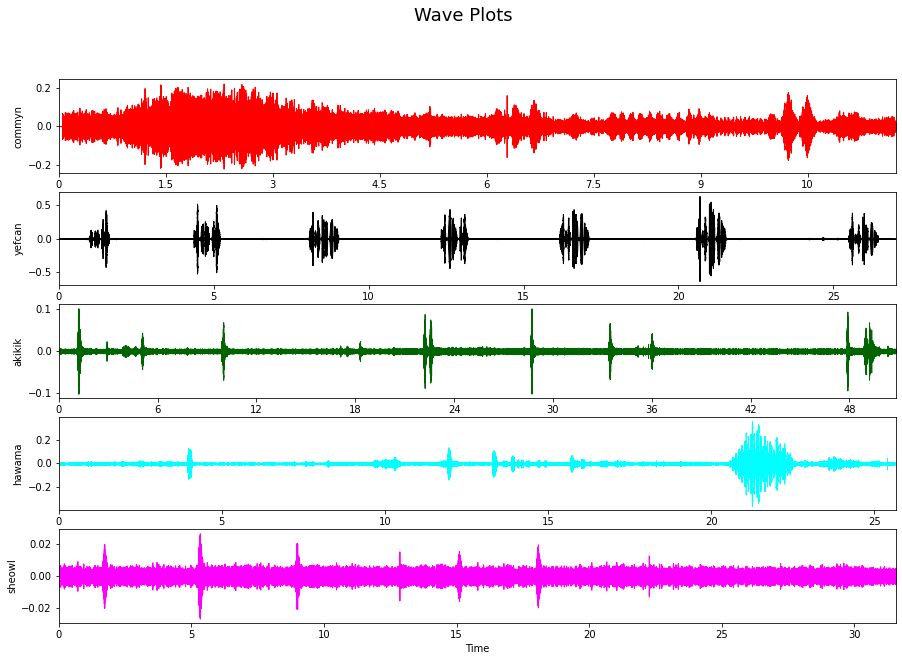

In [ ]:
fig, ax = plt.subplots(5, figsize = (15, 10))
fig.suptitle('Wave Plots', fontsize=18)
colors = ['red', 'black', 'darkgreen', "cyan", "magenta"]

for i in range(5):
  cur_bird = birds[i]
  data, sr = bird_samps[cur_bird]
  ax[i].set_ylabel(cur_bird)
  lr.display.waveplot(y = data, sr = sr, color = colors[i], ax=ax[i])

From these waveforms we can observe the different calling styles of the birds. The calls of birds can be observed from the sudden rise in aplitudes in the waveforms and the intervals of these call can be taken as a feature to identify the species of a bird.

However, this is not enough, as we can observe in the case of "commyn", there is no sudden rise in the amplitude, rather the audio has a uniformly sounding loudness in the beginning. This is due to the background noise which is not distinguishable from the amplitude but can be distinguished from it's frequency as it has a rather low frequency as compared to the bird calls.

### Spectrogram

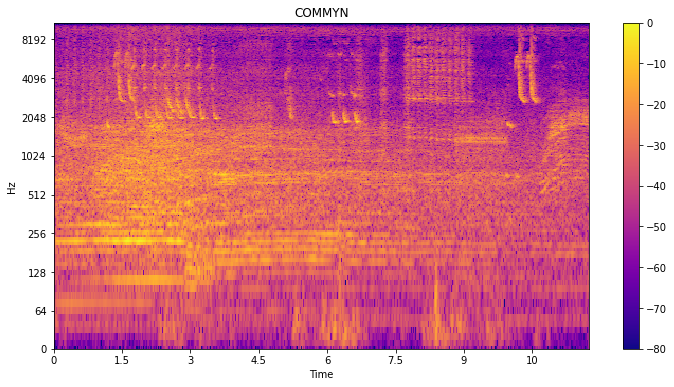

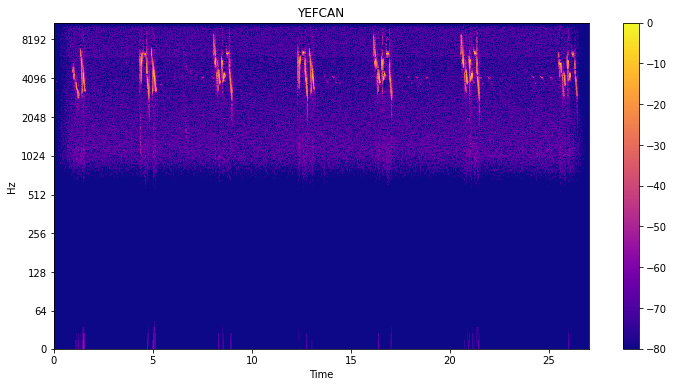

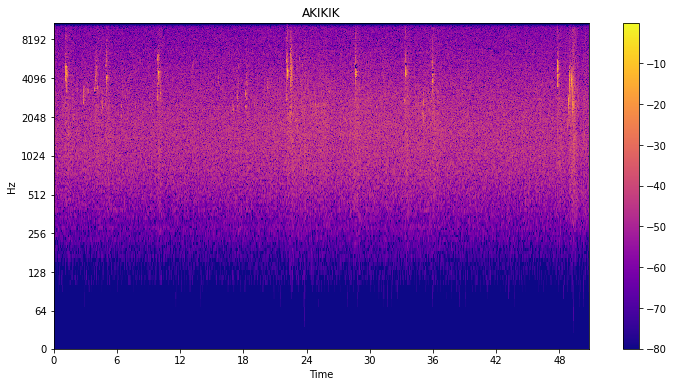

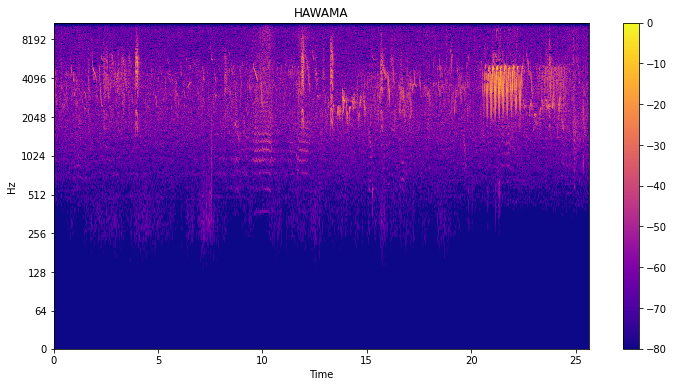

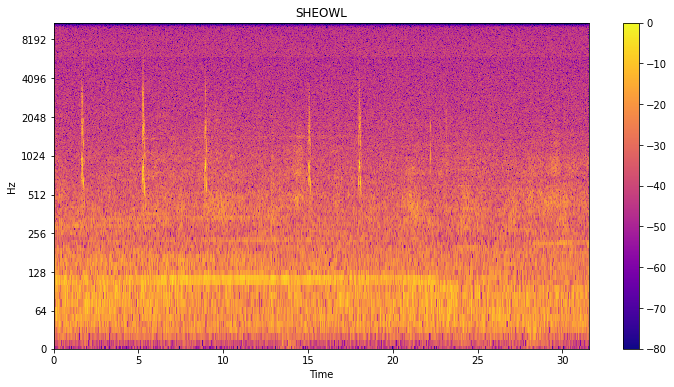

In [ ]:
def spectrogram(bird_name):
  # Short-time Fourier transform (STFT)
  transform = np.abs(lr.stft(bird_samps[bird_name][0]))

  # Convert an amplitude spectrogram to Decibels-scaled spectrogram.
  DB_transform = lr.amplitude_to_db(transform, ref = np.max)

  # === PLOT ===
  fig, ax = plt.subplots(1, 1, figsize=(12, 6))

  plot = librosa.display.specshow(DB_transform, sr = bird_samps[bird_name][1], x_axis = 'time', y_axis = 'log', cmap = 'plasma', ax=ax)
  plt.title(bird_name.upper(), fontsize=12) 
  plt.colorbar(plot, ax=ax)

for bird in birds:
  spectrogram(bird)

From these log frequency spectrograms we can see a spectrum of frequencies as it varies with time. This plot represents signal strength over time at various frequencies present in a particular waveform.We have depicted as a heat map, i.e., as an image with the energy levels (in dB) shown by varying the color or brightness.

We have used stft(), which is short term Fourier Transform. This function is used to determine the sinusoidal frequency and phase content of local sections of a signal as it changes over time. This enables us to know the amplitude of any particular frequency at any given time within the audio.

Here, we can see that the "yefcan" has the cleanest audio, with only the bird calls at a high frequency and little to no noise, while, in case of "commyn", there is a lot of noise, especially in the beginning of the clip. This can be seen in the spectrogram in the where the amplitude of the low frequecies is very high. "akik" and "hawama" also have relatively clean audios, however, from the very light tint of yellow we can see that the audios are much quieter. As for "sheowl", we can see that there is a uniform background noise which is low frequency. If we listen to the audio while observing the plot, we can discern the bird calls are the straight lines in the range of 512 to 4096 hz.

### Seperation of Harmonic and Percussive signals

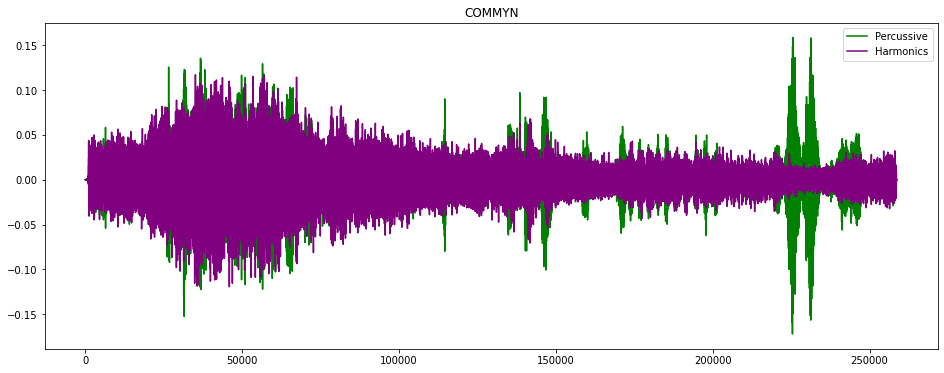

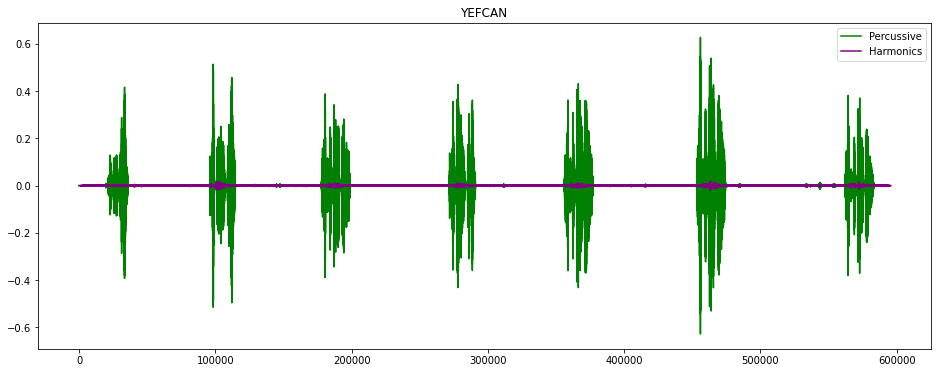

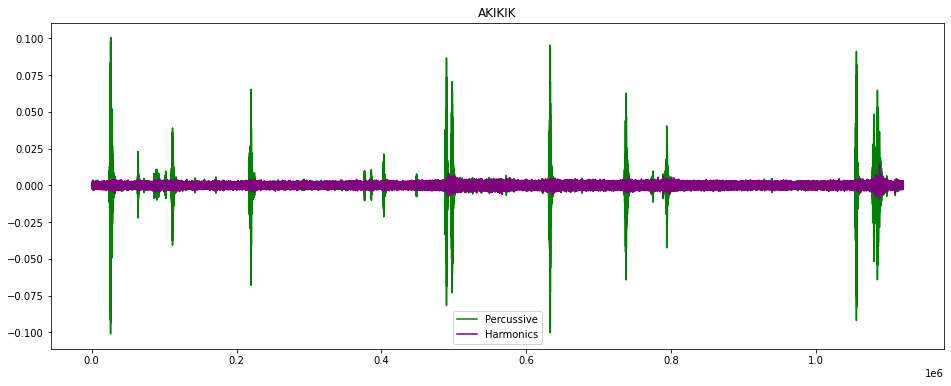

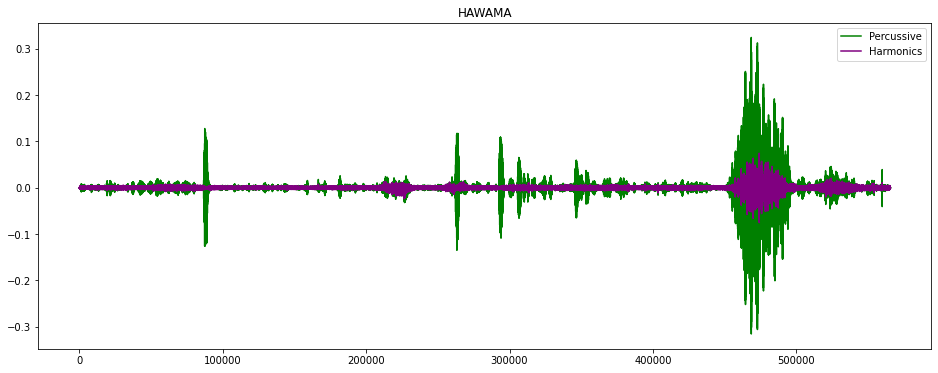

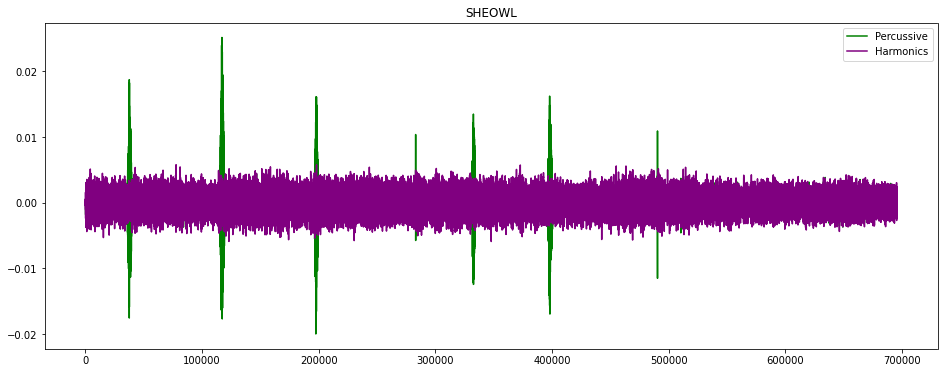

In [ ]:
def bird_hpss(bird_name):
  harm, perc = librosa.effects.hpss(bird_samps[bird_name][0])
  transform = np.abs(librosa.stft(bird_samps[bird_name][0]))
  DB_transform = librosa.amplitude_to_db(transform, ref = np.max)
  plt.figure(figsize = (16, 6))
  plt.plot(perc, label="Percussive", color = 'green')
  plt.plot(harm, label="Harmonics", color = 'purple')
  plt.title(bird_name.upper(), fontsize=12)
  plt.legend()
  plt.show()

for bird in birds:
  bird_hpss(bird)

Every real world audio in the world is combination of Harmonics and Percussive in some propertions. Harmonic sounds are the ones which we perceive to have a certain pitch such that we can hear different notes clearly. The sound of a cello or a violin is a good example of a harmonic sound. Percussive sounds often stem from two colliding objects like for example the crash of a drum. An important characteristic of percussive sounds is that they do not have a pitch but a very clear localization in time.<br>
Therefore we can use this seperation to differentiate between the noise and the bird calls. Here, we have applied harmonic percussive source separation (HPSS) on the sampled 5 bird audio clips and we can see that we have successfully seperated the bird sounds from the background noise. However, contrary to general cases the noise is the harmonic part in the audios represents the noise while the percussive part represents the bird sounds.<br>
This is very useful, especially in cases like audio of "commyn" where there is a lot of background noise and can cause inconsistencies in learning and predicting the data.

<h4>HPSS for COMMYN</h4>

In [ ]:
harm, perc = librosa.effects.hpss(bird_samps['commyn'][0])
harm.shape

(258779,)

In [ ]:
Audio(data=perc, rate=bird_samps['commyn'][1])

In [ ]:
Audio(data=bird_samps['commyn'][0], rate=bird_samps['commyn'][1])

<h4>HPSS for SHEOWL</h4>

In [ ]:
harm, perc = librosa.effects.hpss(bird_samps['sheowl'][0])
perc.shape

(695808,)

In [ ]:
Audio(data=perc, rate=bird_samps['sheowl'][1])

In [ ]:
Audio(data=bird_samps['sheowl'][0], rate=bird_samps['sheowl'][1])

## Extracting Features from Audio Files

Mel Frequency Cepstral Coefficients, is a low rank approximation of the large array of audio data. MFCC features represent phonemes, which are distinct units of sound as the shape of the vocal tract, which is responsible for sound generation, is manifest in them.
Thus, we can use this to extract features from the audio data, and then use them to cluster and predict the bird calls.

In [ ]:
df_prep = []
with tf.device('/device:GPU:0'):
  count = 0
  for folder_name in os.listdir(data_path + "train_audio/"):
    for file_name in os.listdir(data_path + "train_audio/" + folder_name):
      data, samplerate = lr.load(data_path + "train_audio/" + folder_name + "/" + file_name)
      samp_feats = lr.feature.mfcc(data, sr, n_mfcc=45)
      feats = np.mean(samp_feats.T, axis=0)
      df_prep.append((folder_name, feats))
    count += 1
    print(count)
len(df_prep)

In [ ]:
len(glob(data_path + "train_audio/*"))

152

In [ ]:
class_data = pd.DataFrame(df_prep,columns=['Class', 'Features'])
class_data.head()

Class                                           Features
0  afrsil1  [-203.40775, 131.14656, 30.51642, 20.378548, 3...
1  afrsil1  [-408.04178, -26.396112, -125.49046, -63.44708...
2  afrsil1  [-328.93854, -91.08659, -52.83298, -33.43477, ...
3  afrsil1  [-307.25946, 31.206131, 13.461659, 16.671452, ...
4  afrsil1  [-361.91742, -43.730507, -82.150696, -8.310905...

### Storing Dataframe to Drive

In [ ]:
class_data.to_pickle("Class_Data")

In [ ]:
data_path

'drive/MyDrive/Data Science/Project/'

In [ ]:
# Reading the Data

df = pd.read_pickle(data_path + "Class_Data1")
df.head()

Features    Class
0  [-209.92915, 140.34518, 21.45266, 29.219751, -...  afrsil1
1  [-415.5394, -15.8205805, -135.92946, -53.23913...  afrsil1
2  [-337.70877, -79.26804, -65.066345, -21.97864,...  afrsil1
3  [-313.7879, 40.414795, 4.3869452, 25.524931, -...  afrsil1
4  [-370.40985, -31.755713, -93.99737, 3.2971594,...  afrsil1

In [ ]:
df.shape

(14852, 2)

In [ ]:
print("Total Classes of Birds:", np.unique(df.Class).shape[0])

Total Classes of Birds: 152


### Splitting Data

In [ ]:
X = np.array(list(df['Features']))
Y = np.array(list(df['Class']))

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.1, random_state=42)

In [ ]:
np.unique(Y_train).shape

(152,)

In [ ]:
np.unique(Y_test).shape

(137,)

In [ ]:
train_df = pd.DataFrame({"Labels": Y_train, "Features": list(X_train)})
train_df.head()

Labels                                           Features
0   skylar  [-498.13647, 114.06378, -65.07417, 62.54527, -...
1   dunlin  [-531.0084, 92.8339, 23.851942, 52.226406, 10....
2   spodov  [-304.95215, 52.436703, -67.286125, -7.3401904...
3  mallar3  [-239.85378, 93.89339, -19.248438, 11.662527, ...
4   houfin  [-159.12102, 83.20416, -15.237701, 23.408512, ...

## K-Means Clustering

In [ ]:
kmeans = KMeans(n_clusters=152, random_state=0)

# Processing Data to feed

arr = list(train_df['Features'])
total_vec = np.array(arr)

# Fitting into model

kmeans.fit(X_train)

KMeans(n_clusters=152, random_state=0)

In [ ]:
train_df['KMeans_labels'] = kmeans.labels_
train_df.tail()

Labels                                           Features  \
13361   gadwal  [-317.76923, -17.427738, -59.523705, 17.863008...   
13362   snogoo  [-280.6155, 93.06674, -42.597492, 2.0105586, -...   
13363   gadwal  [-447.0736, 69.91873, -55.17398, -30.237787, -...   
13364  belkin1  [-240.77838, 49.498287, -20.799982, 3.7872143,...   
13365   houspa  [-437.36765, -11.90059, -61.57669, 10.470467, ...   

       KMeans_labels  
13361             65  
13362             83  
13363             71  
13364             57  
13365            124

Making a label map, which contains mapping from bird class names to the number labels that the clustering algorithm assigns. We are taking the mode of the number labels which occuring in a particular bird class as the number label for that bird class

In [ ]:
label_map = {}
for lab in np.unique(train_df.Labels):
  samp = train_df[train_df['Labels'] == lab]
  counts = Counter(samp.KMeans_labels)
  num_lab = sorted(counts.items(), key=lambda x: x[1], reverse=True)[0][0]
  label_map[lab] = num_lab

In [ ]:
len(label_map)

152

In [ ]:
# Predicting Using KMeans

Y_hat = kmeans.predict(X_test)
Y_hat

array([117,  34,  86, ...,   7, 101,  59], dtype=int32)

In [ ]:
Y_test_nums = np.array([label_map[i] for i in Y_test])
Y_test_nums

array([ 87,  67,   5, ...,  73, 127,  34])

In [ ]:
print("Accuracy:", np.sum(Y_hat == Y_test_nums) / len(Y_hat))

Accuracy: 0.03835800807537012


## Gaussian Mixture Clustering

In [ ]:
X_train.shape

(13366, 45)

In [ ]:
normal_model = GaussianMixture(n_components=152, random_state=0)
with tf.device('/device:GPU:0'):
  labels = normal_model.fit_predict(X_train)

In [ ]:
labels.shape

(13366,)

In [ ]:
train_df["SC_Labels"] = labels
train_df.head()

Labels                                           Features  b_Labels  \
0   skylar  [-498.13647, 114.06378, -65.07417, 62.54527, -...        26   
1   dunlin  [-531.0084, 92.8339, 23.851942, 52.226406, 10....       123   
2   spodov  [-304.95215, 52.436703, -67.286125, -7.3401904...         9   
3  mallar3  [-239.85378, 93.89339, -19.248438, 11.662527, ...        72   
4   houfin  [-159.12102, 83.20416, -15.237701, 23.408512, ...        19   

   SC_Labels  
0          0  
1         24  
2        133  
3        128  
4        133

In [ ]:
label_map = {}
for lab in np.unique(train_df.Labels):
  samp = train_df[train_df['Labels'] == lab]
  counts = Counter(samp.SC_Labels)
  num_lab = sorted(counts.items(), key=lambda x: x[1], reverse=True)[0][0]
  label_map[lab] = num_lab

In [ ]:
len(label_map)

152

In [ ]:
Y_hat = normal_model.predict(X_test)
Y_hat.shape

(1486,)

In [ ]:
Y_test_nums = np.array([label_map[i] for i in Y_test])
Y_test_nums.shape

(1486,)

In [ ]:
print("Accuracy:", np.sum(Y_hat == Y_test_nums) / len(Y_hat))

Accuracy: 0.32166890982503366


## Birch Clustering

In [ ]:
b_model = Birch(n_clusters=152)
b_model.fit(X_train)

Birch(n_clusters=152)

In [ ]:
train_df["b_Labels"] = b_model.labels_
train_df.head()

Labels                                           Features  b_Labels
0   skylar  [-498.13647, 114.06378, -65.07417, 62.54527, -...        26
1   dunlin  [-531.0084, 92.8339, 23.851942, 52.226406, 10....       123
2   spodov  [-304.95215, 52.436703, -67.286125, -7.3401904...         9
3  mallar3  [-239.85378, 93.89339, -19.248438, 11.662527, ...        72
4   houfin  [-159.12102, 83.20416, -15.237701, 23.408512, ...        19

In [ ]:
label_map = {}
for lab in np.unique(train_df.Labels):
  samp = train_df[train_df['Labels'] == lab]
  counts = Counter(samp.b_Labels)
  num_lab = sorted(counts.items(), key=lambda x: x[1], reverse=True)[0][0]
  label_map[lab] = num_lab

In [ ]:
len(label_map)

152

In [ ]:
Y_hat = b_model.predict(X_test)
Y_hat.shape

(1486,)

In [ ]:
Y_test_nums = np.array([label_map[i] for i in Y_test])
Y_test_nums.shape

(1486,)

In [ ]:
print("Accuracy:", np.sum(Y_hat == Y_test_nums) / len(Y_hat))

Accuracy: 0.0370121130551817


# Classifiers

### Random Forest Classifier

In [ ]:
from sklearn.metrics import accuracy_score

In [ ]:
rfc = RandomForestClassifier(n_estimators = 200)
rfc.fit(X_train, Y_train)

RandomForestClassifier(n_estimators=200)

In [ ]:
Y_hat = rfc.predict(X_test)
Y_hat.shape

(1486,)

In [ ]:
accuracy_score(Y_test, Y_hat)

0.2604306864064603